## Regional Pricing & Fare Efficiency Modeling

In this section, we explore whether regional and time-based factors influence fare efficiency using regression models. We aim to predict fare-per-mile based on trip distance, pickup hour, and pickup location (borough).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('uber_cleaned.csv')

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_hour,pickup_dayofweek
0,52:06.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.68,19,Thursday
1,04:56.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.46,20,Friday
2,45:00.0,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.04,21,Monday
3,22:21.0,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.66,8,Friday
4,47:00.0,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.48,17,Thursday


### Feature Engineering

We create a `fare_per_mile` feature to compare pricing efficiency across trips, and classify each trip into a borough based on pickup latitude and longitude. These features allow us to analyze geographic and time-based patterns in Uber fares.

In [4]:
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance'].replace(0, np.nan)

df = df[df['fare_per_mile'].notnull() & np.isfinite(df['fare_per_mile'])]

In [5]:
df[['fare_amount', 'trip_distance', 'fare_per_mile']].head()

,fare_amount,trip_distance,fare_per_mile
0,7.5,1.68,4.464286
1,7.7,2.46,3.130081
2,12.9,5.04,2.559524
3,5.3,1.66,3.192771
4,16.0,4.48,3.571429


In [9]:
def classify_borough(lat, lon):
    if (40.70 <= lat <= 40.88) and (-74.03 <= lon <= -73.92):
        return 'Manhattan'
    elif (40.57 <= lat <= 40.73) and (-74.05 <= lon <= -73.85):
        return 'Brooklyn'
    elif (40.65 <= lat <= 40.80) and (-73.96 <= lon <= -73.70):
        return 'Queens'
    elif (40.80 <= lat <= 40.91) and (-73.93 <= lon <= -73.80):
        return 'Bronx'
    elif (40.49 <= lat <= 40.65) and (-74.25 <= lon <= -74.05):
        return 'Staten Island'
    else:
        return 'Other'

df['borough'] = df.apply(lambda row: classify_borough(row['pickup_latitude'], row['pickup_longitude']), axis=1)

df['borough'].value_counts()

borough
Manhattan        182514
Queens             5060
Other              2942
Brooklyn           2569
Bronx               108
Staten Island        10
Name: count, dtype: int64

### Data Preparation

We one-hot encode the borough variable and split the data into training and testing sets. This prepares the data for model training while ensuring we can evaluate model performance on unseen data.

In [10]:
df_encoded = pd.get_dummies(df, columns=['borough'], drop_first=True)

X = df_encoded[['trip_distance', 'pickup_hour'] + [col for col in df_encoded.columns if col.startswith('borough_')]]
y = df_encoded['fare_per_mile']

X.shape, y.shape

((193203, 7), (193203,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((154562, 7), (38641, 7), (154562,), (38641,))

### Gradient Boosting Model

We first train a Gradient Boosting Regressor. This model handles complex interactions well and is often effective on structured tabular data. We evaluate its performance on the test set using Root Mean Squared Error (RMSE).

In [12]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f'Gradient Boosting RMSE: {rmse_gb:.4f}')

Gradient Boosting RMSE: 52.1501


### Random Forest Model

For comparison, we also train a Random Forest Regressor. We will compare its RMSE to the Gradient Boosting model and analyze any differences in performance.

In [13]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f'Random Forest RMSE: {rmse_rf:.4f}')

Random Forest RMSE: 54.5558


### RMSE Comparison

We compare the RMSE of both models to assess overall accuracy and potential overfitting. Lower RMSE indicates better predictive performance.

/tmp/ipykernel_2946544/99243490.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=rmse_values, palette='pastel')


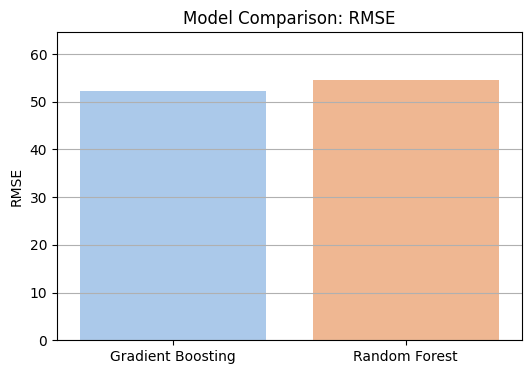

In [14]:
rmse_values = [rmse_gb, rmse_rf]
model_names = ['Gradient Boosting', 'Random Forest']

plt.figure(figsize=(6, 4))
sns.barplot(x=model_names, y=rmse_values, palette='pastel')
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 10)
plt.grid(axis='y')

plt.show()

### Feature Importance

Feature importance plots help us understand which variables are driving the model’s predictions. This provides insight into the factors that most influence fare-per-mile.

/tmp/ipykernel_2946544/1066916870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gb_feat_df, x='Importance', y='Feature', palette='viridis')


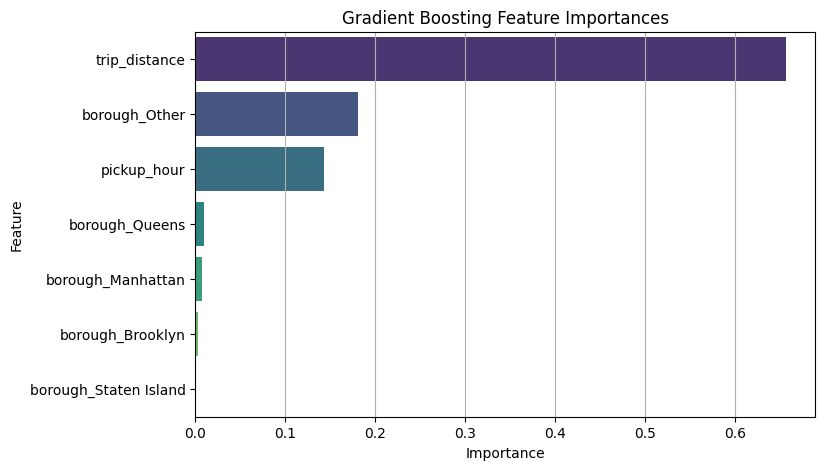

In [15]:
gb_importances = gb_model.feature_importances_
feature_names = X.columns

gb_feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_importances})
gb_feat_df = gb_feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=gb_feat_df, x='Importance', y='Feature', palette='viridis')
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x')

plt.show()

/tmp/ipykernel_2946544/2030120876.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_feat_df, x='Importance', y='Feature', palette='magma')


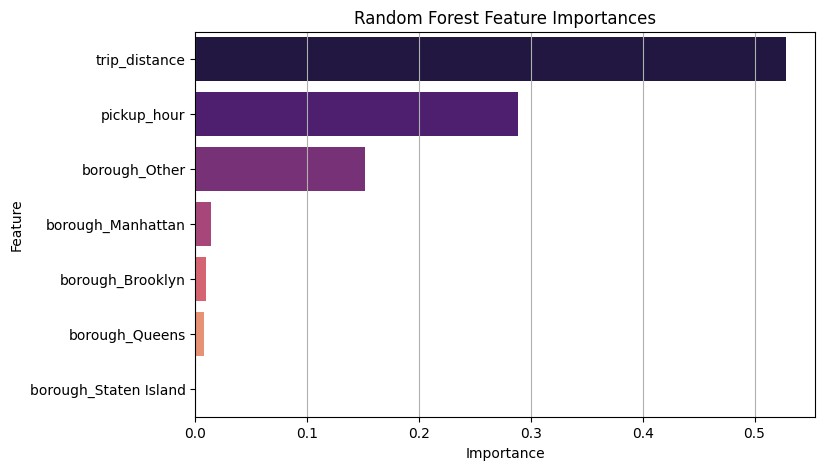

In [16]:
rf_importances = rf_model.feature_importances_

rf_feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_feat_df = rf_feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=rf_feat_df, x='Importance', y='Feature', palette='magma')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x')

plt.show()

### Actual vs. Predicted Plot

An Actual vs. Predicted plot allows us to visually assess how well the Gradient Boosting model fits the data across fare-per-mile values. Points close to the diagonal line indicate good predictions.


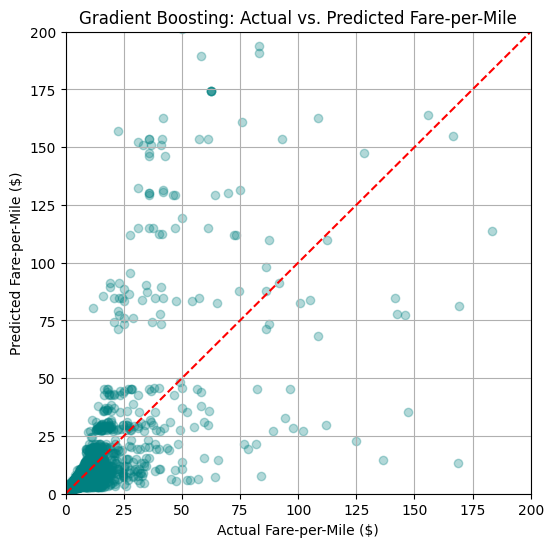

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Gradient Boosting: Actual vs. Predicted Fare-per-Mile')
plt.xlabel('Actual Fare-per-Mile ($)')
plt.ylabel('Predicted Fare-per-Mile ($)')
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.grid(True)

plt.show()

### Residual Plot

The Residual Plot helps us check for model bias and whether prediction errors are consistent across the range of fare-per-mile predictions. Ideally, residuals should be centered around zero with no clear patterns.

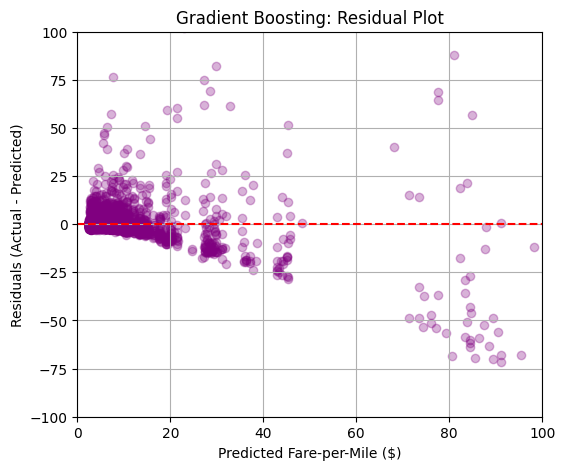

In [24]:
residuals_gb = y_test - y_pred_gb

plt.figure(figsize=(6, 5))
plt.scatter(y_pred_gb, residuals_gb, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Gradient Boosting: Residual Plot')
plt.xlabel('Predicted Fare-per-Mile ($)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.grid(True)

plt.show()

Our modeling results show that trip distance is by far the strongest factor influencing fare-per-mile, which makes sense given how Uber pricing is structured. Borough and pickup hour also have meaningful effects, especially in identifying cases where pricing may be less consistent. Gradient Boosting slightly outperformed Random Forest on this task, achieving a lower RMSE, and both models highlighted similar feature importance trends. Overall, this analysis supports the idea that regional and time-based factors do impact fare efficiency, which could be useful for informing dynamic pricing strategies.